#### Neural network classification
- binary classification (example: dog or cat)
- multiclass classification (more than 2 classes)

#### What we're going to cover

- Architecture of a neural network classification model
- Input shapes and output shapes of a classification model (features and labels)
- Creating custom data to view, fit on and predict on
- Steps in modelling:
    - creating a model
    - setting up loss function and optimizer
    - creating a training loop
    - evaluating a model
- Saving and loading a models
- Harnessing the power of non-linearity
- Different classification evaluation methods

#### Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

Of course, this ingredient list of classification neural network components will vary depending on the problem you're working on.

But it's more than enough to get started.

We're going to gets hands-on with this setup throughout this notebook.

In [2]:
# batch size (32 is commonly used in practice)

# Make classification data and get it ready

import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 X features:\n{X[:5]}\n{X.shape}") # X has 2 features (x1, x2)
print(f"First 15 y labels:\n{y[:15]}") # y is binary (0 or 1)

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
(1000, 2)
First 15 y labels:
[1 1 1 1 0 1 1 1 1 0 1 0 1 1 1]


In [5]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


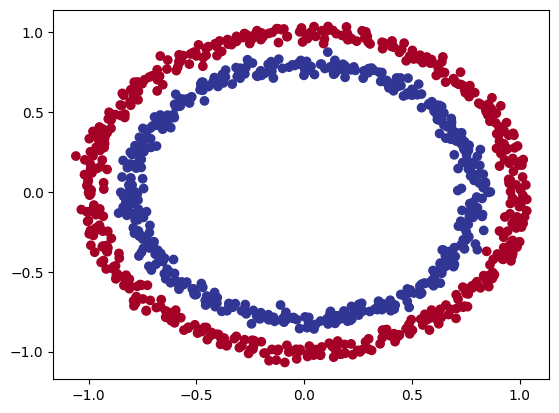

In [6]:
# visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu); # cmap = color map

In [7]:
#### 1.1 check input and output shapes

X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print("Shapes for one sample of X: ", X_sample.shape, "and the same for y: ", y_sample.shape)

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X:  (2,) and the same for y:  ()


In [9]:
### 1.2 Turn data into tensors and create train/test splits

import torch
torch.__version__

# Turn data into tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

#### 2. Building a model

Lets build a model to classify blue and red dots

To do so we want:
1. setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and an optimizer
4. Create training and testing loop

In [13]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


now we will:
- Subclass `nn.Module` (almost all models in PyTorch inherit from `nn.Module`)
- Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
    - `nn.Linear()` is an **activation function**
- Defines a `forward()` method that outlines the forward pass (forward computation)
- Instantiate an instance of our model class and send it to the target device

In [14]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Linear() will create weights and bias automatically with the formula y = wx + b
        # the more output features, the more patterns the model will learn
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # out_features is commonly a multiple of 8
        # takes in 5 features (from prev layer) and outputs 1 feature (same shape as y)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x

In [15]:
# Create an instance of the model
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

### Making our model visual
- [Tensorflow playground](playground.tensorflow.org/)
- [Figma draw](figjam.new)

### Lets replicate the model above using nn.Sequential
Sequential does exactly the same thing as the class above, but it's easier to read and write

In [17]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()
# in linear layer 1, since there are 2 input features, then we have 2 weights (ex: [-0.0225,  0.2731])
# and since we have out_features = 5, then we get 5 biases ([ 0.4726, -0.1026,  0.6819,  0.2507, -0.4860])
# total number of weights in layer 1 = 2 (in_features) * 5 (out_features) = 10 (total weights)

OrderedDict([('0.weight',
              tensor([[ 0.3422, -0.2854],
                      [-0.0491,  0.3673],
                      [-0.3271, -0.3975],
                      [ 0.5767, -0.0960],
                      [-0.5043, -0.0157]])),
             ('0.bias', tensor([-0.4512,  0.0313, -0.5648, -0.1017,  0.6522])),
             ('1.weight',
              tensor([[ 0.2562, -0.1361,  0.3738, -0.0552, -0.0360]])),
             ('1.bias', tensor([0.1209]))])

In [19]:
with torch.inference_mode():
    untrained_preds = model_0(X_test)

    print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
    print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
    print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}\n")
    print(f"First 10 test labels:\n{y_test[:10]}")
    print(f"Are predictions same as labels? {torch.all(torch.eq(untrained_preds, y_test))}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.3938],
        [-0.4838],
        [-0.1150],
        [-0.4730],
        [-0.0469],
        [-0.1024],
        [-0.4097],
        [-0.3202],
        [-0.1183],
        [-0.4891]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
Are predictions same as labels? False


#### 2.1 Setup loss function and optimizer

##### Loss function

For regression kind of problem we might want:
- MAE (mean absolute error) - `torch.nn.L1Loss`
- MSE (mean squared error) - `torch.nn.MSELoss`

For classification kind of problem we might want:
- BCE (binary cross entropy) - `torch.nn.BCEWithLogitsLoss` or `torch.nn.BCELoss`
    - important: read about **logits layer**
- Categorical cross entropy - `torch.nn.CrossEntropyLoss`

##### Optimizers

2 of the most common and useful optimizers are:

- SGD (stochastic gradient descent) - `torch.optim.SGD`
- Adam - `torch.optim.Adam`

however, you can find more options in [`torch.optim`](https://pytorch.org/docs/stable/optim.html)

##### Links

- [MAE/MSE/BCE](https://nadeemm.medium.com/cost-function-loss-function-c3cab1ddffa4)
- [BCE explained](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

In [20]:
# set up loss function and optimizer
# BCELoss requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
# loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss() # has Sigmoid activation function built-in
# BCEWithLogitsLoss combines nn.BCELoss() and nn.Sigmoid()
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [21]:
# Calculate accuracy (a classification metric), out of 100 examples, how many (%) were correct?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.tensor([1.0]).item() => 1.0
    acc = (correct / len(y_pred)) * 100
    return acc

#### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

our model outputs are going to be raw **logits**

we can convert these **logits** to **prediction probabilities** by passing them to some kind of activation function (ex: sigmoid for binary cross entropy (classification), Softmax for multiclass classification)

Then we convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the class with the highest probability with `torch.argmax()`

In [22]:
# training loop steps
with torch.inference_mode():    
    y_logits = model_0(X_test)

print(y_logits[:5])
print(y_test[:5])

tensor([[-0.3938],
        [-0.4838],
        [-0.1150],
        [-0.4730],
        [-0.0469]])
tensor([1., 0., 1., 0., 1.])


In [23]:
# use the sigmoid function to convert logits -> prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.3938],
        [-0.4838],
        [-0.1150],
        [-0.4730],
        [-0.0469]])
tensor([[0.4028],
        [0.3814],
        [0.4713],
        [0.3839],
        [0.4883]])


For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5 --> y = 1 (class 1)
* `y_pred_probs` < 0.5 --> y = 0 (class 0)

In [24]:
# find the predicted labels
y_pred = torch.round(y_pred_probs)

# in full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test)))

# check for equality

# get rid of extra dimension
print(y_pred[:5].squeeze())
print(y_pred_labels[:5].squeeze())
print(torch.eq(y_pred[:5].squeeze(), y_pred_labels[:5].squeeze()))

tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
tensor([True, True, True, True, True])


In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()

    # y_logits = model_0(X_train) -> logits
    # y_pred = torch.sigmoid(logits) -> prediction probabilities
    # y_label = torch.round(pred) -> prediction labels
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #                   y_train)
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward - backpropagation
    loss.backward()

    # 5. Optimizer step - gradient descent
    optimizer.step()

    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test.squeeze())
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_accuracy:.2f}%")

Epoch: 0 | Loss: 0.70452 | Accuracy: 41.25% | Test loss: 0.69752 | Test acc: 43.50%
Epoch: 10 | Loss: 0.69929 | Accuracy: 46.12% | Test loss: 0.69296 | Test acc: 50.00%
Epoch: 20 | Loss: 0.69736 | Accuracy: 47.50% | Test loss: 0.69145 | Test acc: 53.00%
Epoch: 30 | Loss: 0.69651 | Accuracy: 48.50% | Test loss: 0.69095 | Test acc: 53.50%
Epoch: 40 | Loss: 0.69604 | Accuracy: 48.75% | Test loss: 0.69081 | Test acc: 53.00%
Epoch: 50 | Loss: 0.69572 | Accuracy: 48.75% | Test loss: 0.69079 | Test acc: 53.00%
Epoch: 60 | Loss: 0.69547 | Accuracy: 49.00% | Test loss: 0.69082 | Test acc: 52.50%
Epoch: 70 | Loss: 0.69527 | Accuracy: 49.25% | Test loss: 0.69088 | Test acc: 53.50%
Epoch: 80 | Loss: 0.69508 | Accuracy: 49.38% | Test loss: 0.69094 | Test acc: 53.00%
Epoch: 90 | Loss: 0.69492 | Accuracy: 49.38% | Test loss: 0.69102 | Test acc: 52.00%


In [27]:
circles.label.value_counts()
# 500 samples for each class
# we have a balanced dataset


label
1    500
0    500
Name: count, dtype: int64

### Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything
so to inspect it let's make some predictions and visualize them
- To do so, we're going to import a function called `plot_decision_boundary()` 

In [28]:
import requests
from pathlib import Path

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    with open("helper_functions.py", "wb") as f:
        f.write(requests.get(url).content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


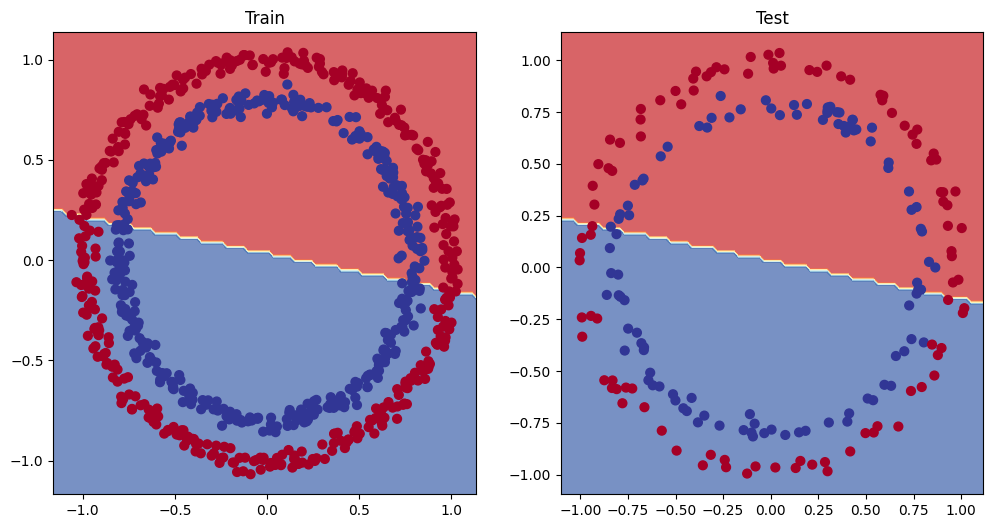

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Explaination

The data is in circular form but we have linear activation functions. No matter how long we train our model, it will not learn anything because linear activation functions lack the capacity to capture the non-linear relationships inherent in circular or complex data structures.

#### Improving the model (from a model perspective)

The following are options that deal directly with the model rather than the data:

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10
...

because these options are all values that we can change, they are referred to as `hyperparameters`.

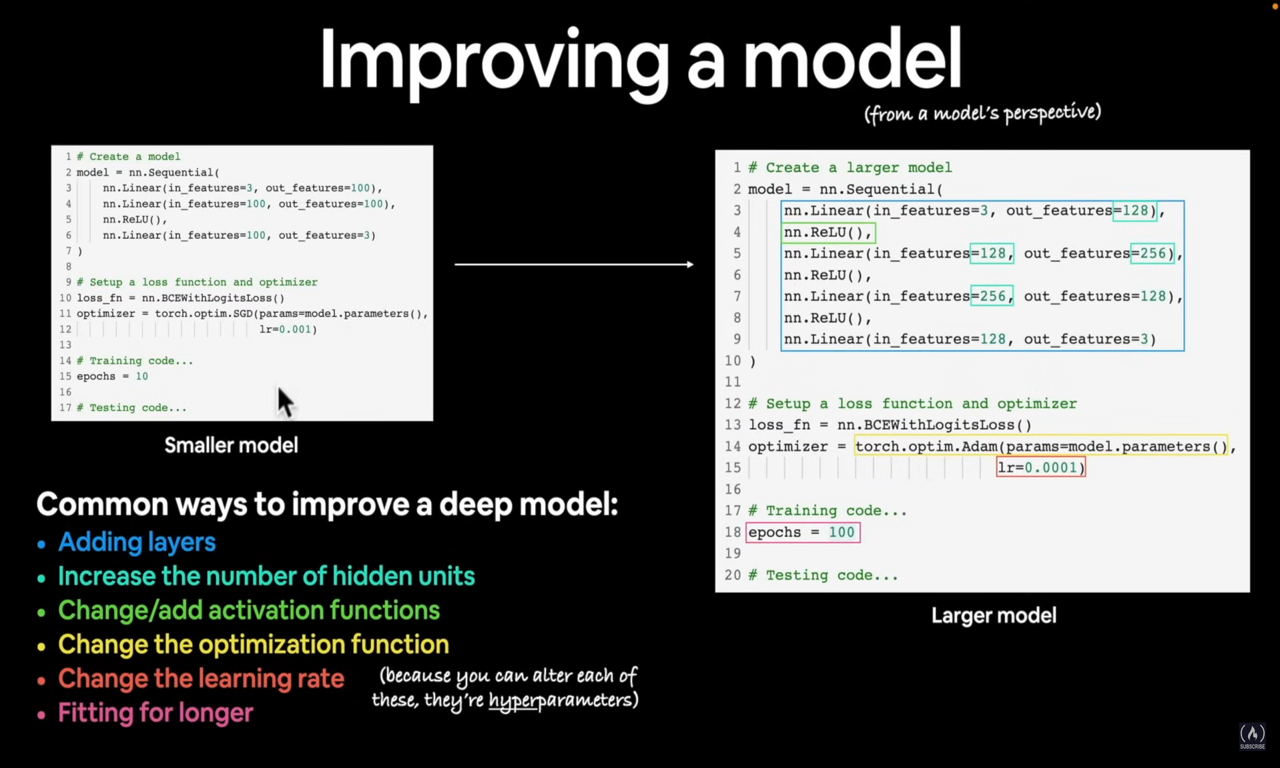

In [33]:
# Improve model by increasing hidden units, number of layers, and number of epochs

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # commonly logits are represented by 'z'
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z
    
model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [34]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)
torch.manual_seed(42)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCEWithLogitsLoss expects raw logits as input
    #                   y_train)
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward - backpropagation
    loss.backward()

    # 5. Optimizer step - gradient descent
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_accuracy:.2f}%")        

Epoch: 0 | Loss: 0.69396 | Accuracy: 50.88% | Test loss: 0.69261 | Test acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Accuracy: 50.38% | Test loss: 0.69379 | Test acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Accuracy: 51.12% | Test loss: 0.69437 | Test acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Accuracy: 51.62% | Test loss: 0.69458 | Test acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Accuracy: 51.12% | Test loss: 0.69465 | Test acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69467 | Test acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69468 | Test acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Accuracy: 51.00% | Test loss: 0.69468 | Test acc: 46.00%


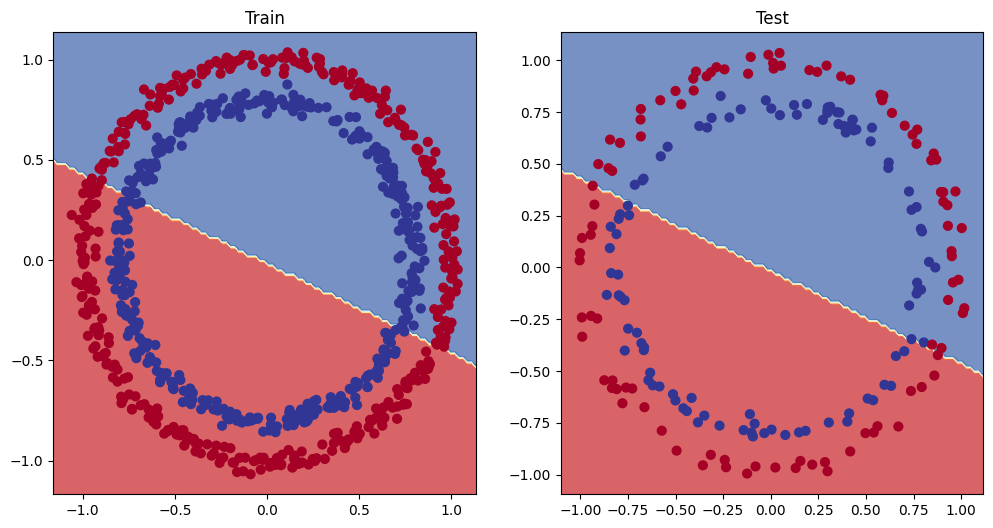

In [35]:
# plot_decision_boundary(model_1, X_test, y_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

#### Preparing data to see if our model can fit a straight line

one way to troubleshoot to a large problem is to test out a smaller problem

In [66]:
# create some data (same as notebook 1)
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias
train_split = int(0.8 * len(X_regression))

X_train, y_train = X_regression[:train_split], y_regression[:train_split]
X_test, y_test = X_regression[train_split:], y_regression[train_split:]
print(X_regression[:5])
print(y_regression[:5])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])
tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])
torch.Size([80, 1]) torch.Size([80, 1]) torch.Size([20, 1]) torch.Size([20, 1])


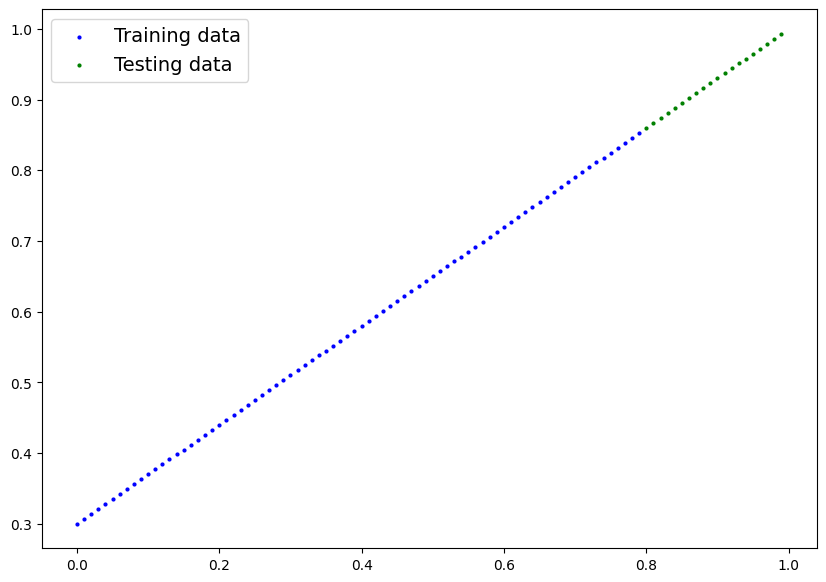

In [40]:
plot_predictions(X_train, y_train, X_test, y_test)

In [105]:
# in_features = 1 in previous model, so we need a new one

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [103]:
loss = nn.L1Loss() # same as MAE
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

epochs = 10000

for epoch in range(epochs):
    model_2.train()

    # 1. Forward pass
    y_pred = model_2(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_2(X_test)

        # 2. Caculate loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 1000 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 2000 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 3000 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 4000 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 5000 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 6000 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 7000 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 8000 | Loss: 0.62598 | Test loss: 0.27452
Epoch: 9000 | Loss: 0.62598 | Test loss: 0.27452


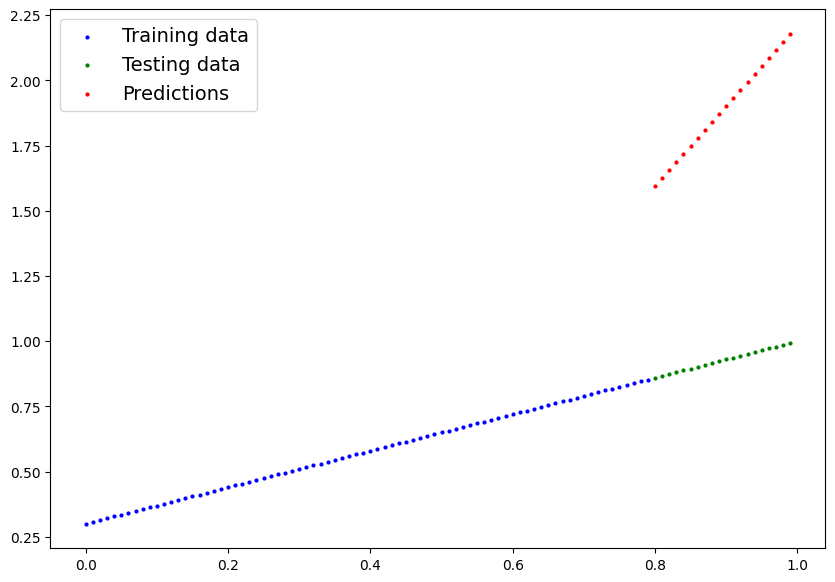

In [91]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test)
    plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds)

#### The missing piece: non-linearity

#### 6.1 Recreating non-linear data (red and clue circles)

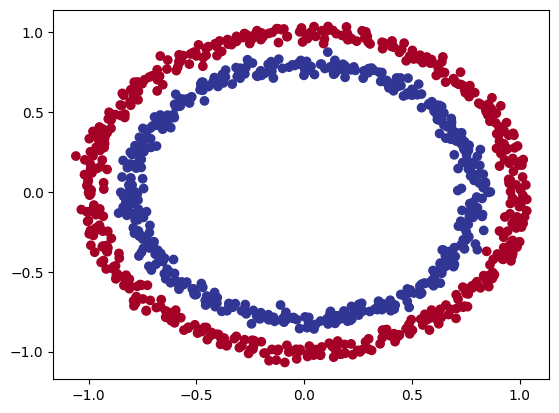

In [107]:
# Make and plot data

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [108]:
# convert data to tensors and then to train and test splits

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

#### 6.2 Build a model with non-linear activation functions
    
* Linear - straight line
* Non-linear - non-straight line    

In [109]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        z1 = self.layer_1(x)
        a1 = self.relu(z1)
        
        z2 = self.layer_2(a1)
        a2 = self.relu(z2)
        
        z3 = self.layer_3(a2)
        return z3

# check tensorflow playground to see what ReLu does
model_3 = CircleModelV2().to(device)
model_3        

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [112]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

epochs = 3000

for epoch in range(epochs):
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # 2. Caculate loss
        test_loss = loss_fn(test_logits, y_test)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f} | Accuracy: {accuracy:.2f}%")

Epoch: 0 | Loss: 0.52309 | Test loss: 0.55567 | Accuracy: 87.50%
Epoch: 100 | Loss: 0.42587 | Test loss: 0.47299 | Accuracy: 91.00%
Epoch: 200 | Loss: 0.31047 | Test loss: 0.36783 | Accuracy: 93.00%
Epoch: 300 | Loss: 0.20125 | Test loss: 0.25829 | Accuracy: 98.50%
Epoch: 400 | Loss: 0.30498 | Test loss: 0.38229 | Accuracy: 79.50%
Epoch: 500 | Loss: 0.09949 | Test loss: 0.14703 | Accuracy: 99.50%
Epoch: 600 | Loss: 0.06979 | Test loss: 0.10971 | Accuracy: 99.00%
Epoch: 700 | Loss: 0.05220 | Test loss: 0.08687 | Accuracy: 99.50%
Epoch: 800 | Loss: 0.04079 | Test loss: 0.07199 | Accuracy: 99.00%
Epoch: 900 | Loss: 0.03271 | Test loss: 0.06135 | Accuracy: 99.00%


In [115]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-3.6675e-01,  1.6894e-01],
                      [-3.4092e-01, -3.0177e-01],
                      [-5.6256e-01, -7.7570e-04],
                      [-1.7256e+00, -6.2122e-01],
                      [ 1.4768e+00, -2.2760e+00],
                      [-1.9271e+00,  7.1170e-01],
                      [ 1.4417e-01,  1.5725e+00],
                      [-4.2917e-01,  2.0104e-01],
                      [ 1.0755e+00,  2.1333e+00],
                      [-2.0269e+00, -6.5944e-01]])),
             ('layer_1.bias',
              tensor([-0.6078, -0.4845,  2.1602,  0.2299,  0.1550, -0.2903, -0.0171, -0.4999,
                       0.0918, -0.4725])),
             ('layer_2.weight',
              tensor([[-0.0793, -0.2747, -0.2415,  0.6022,  0.7683,  0.0201,  0.1316, -0.0352,
                       -0.1276,  0.6932],
                      [ 0.0051,  0.0666, -0.4799,  0.1101,  0.7535,  0.5715,  0.4551, -0.1524,
                        0.8902,  0

In [116]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

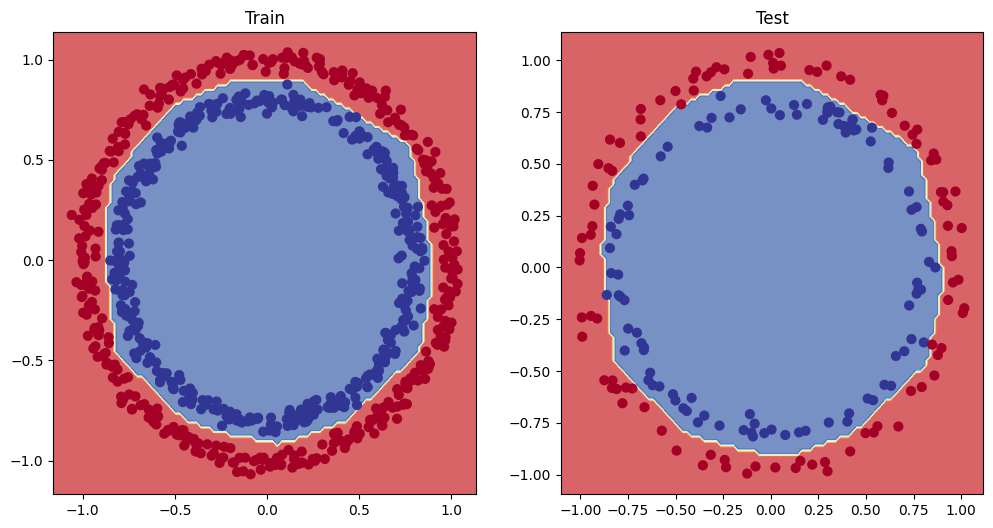

In [117]:
# check tensorflow playground
# check regularization

plot_decision_boundary(model_3, X_test, y_test)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)